In [20]:
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

In [21]:
class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth= 1
    def step(self):
        if self.wealth > 0:
            other_agent = self.random.choice(self.model.schedule.agents)
            other_agent.wealth += 1
            self.wealth -= 1            

In [22]:
class MoneyModel(Model):
    def __init__(self, num_agents):
        self.num_agents = num_agents
        self.schedule = RandomActivation(self)
        
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self .schedule.add(a)
    def step(self):
        self.schedule.step()

In [23]:
model = MoneyModel(10)
for i in range(10):
    model.step()

(array([4., 0., 4., 0., 0., 1., 0., 0., 0., 1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

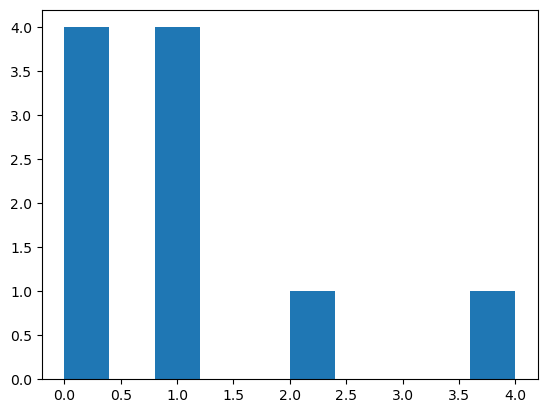

In [24]:
agents_wealth = [agent.wealth for agent in model.schedule.agents]
plt.hist(agents_wealth)

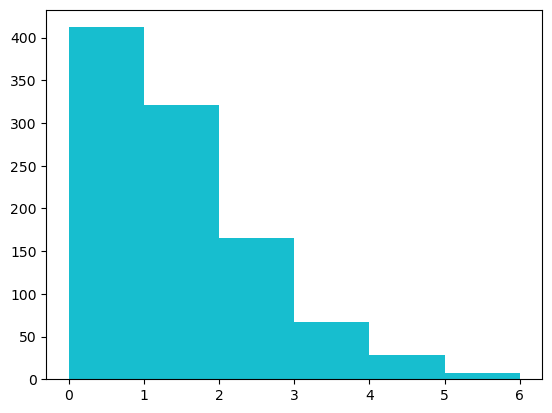

In [25]:
all_wealth = []
for i in range(100):
    model = MoneyModel(10)
    for j in range(10):
        model.step()
    
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)
    
    plt.hist(all_wealth, bins = range(max(all_wealth) + 1) )

# Cambio 1

In [41]:
class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth= 1
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()    
            
    def move(self):
        choices = self.model.grid.get_neighborhood(self.pos, moore= True, include_center = False)
        
        new_position = self.random.choice(choices)
        self.model.grid.move_agent(self, new_position)
        
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1
        

In [42]:
class MoneyModel(Model):
    def __init__(self, num_agents, width, height):
        self.num_agents = num_agents
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)
        
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self .schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
    def step(self):
        self.schedule.step()

In [43]:
model = MoneyModel(50,10,10)
for i in range(20):
    model.step()

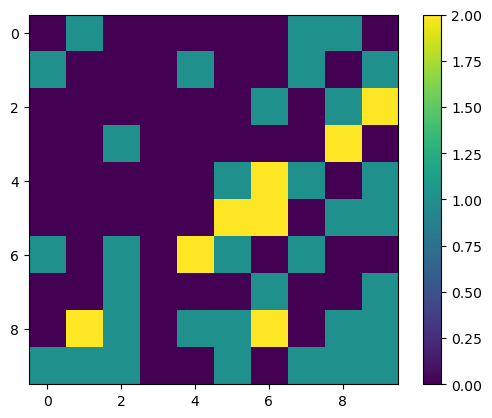

In [44]:
agents_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agents_counts[x][y] = len(cell_content)

plt.imshow(agents_counts, interpolation = 'nearest')
plt.colorbar()

# Cambio 2

In [80]:
class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth= 1
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()    
            
    def move(self):
        choices = self.model.grid.get_neighborhood(self.pos, moore= True, include_center = False)
        
        new_position = self.random.choice(choices)
        self.model.grid.move_agent(self, new_position)
        
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1
        
def compute_gini(model):
    agents_wealth = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agents_wealth)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return (1 + (1 / N) - (2*B))
            

In [81]:
class MoneyModel(Model):
    def __init__(self, num_agents, width, height):
        self.num_agents = num_agents
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)
        
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self .schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        self.datacollector = DataCollector(
            model_reporters = {"Gini" : compute_gini},
            agent_reporters = {"Wealth" : "wealth"})
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [82]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

<AxesSubplot:>

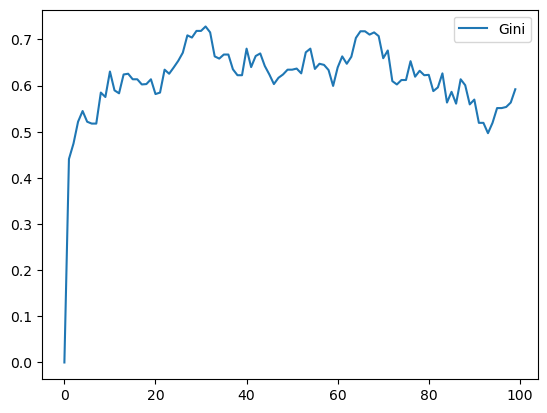

In [83]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [86]:
agents_wealth = model.datacollector.get_agent_vars_dataframe()
agents_wealth.tail(5)

Wealth
Step AgentID        
99   45            0
     46            4
     47            1
     48            1
     49            1

<AxesSubplot:>

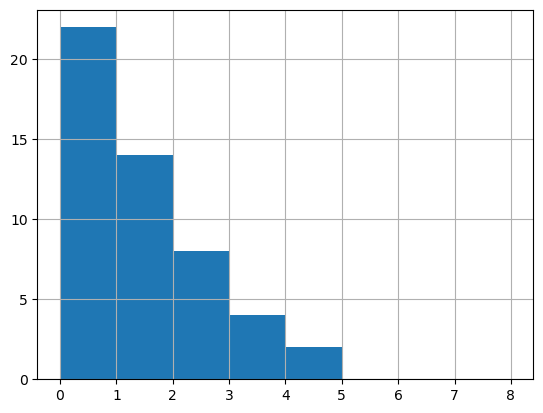

In [88]:
end_wealth = agents_wealth.xs(99, level = "Step")["Wealth"]
end_wealth.hist(bins = range(agents_wealth.Wealth.max() + 1))

# Cambio 3

In [ ]:
fixed_params = {"width": 10, "height": 10}
variable_params = {"num_agents": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel, variable_params, fixed_params, iterations = 5, 
                        max_steps = 100, model_reporters={"Gini": compute_gini})

batch_run.run_all()